# ECON 626 Prediction Competition 6 Code

Objective: To predict using classification which of the 15,578 text snippets from news articles include the words
“economic”,“economy”, “economics” or the character sequence “econom” (not case-sensitive) in it.

### Importing libraries

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import LabelEncoder

import nltk
from nltk.stem import PorterStemmer
from nltk import LancasterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.metrics import edit_distance
import string
import re
from bs4 import BeautifulSoup 

from wordcloud import WordCloud

from collections import Counter

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.feature_extraction.text import TfidfTransformer

from sklearn import preprocessing

from sklearn import svm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score

from sklearn.model_selection import GridSearchCV

from scipy.sparse import hstack

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

### Importing data

In [82]:
data_path = "/Users/andrew/Downloads/UW courses/ECON 626/Prediction Competition 6/MLforEcon_W2024_pc6_data_without_response_v2.csv"
text_df= pd.read_csv(data_path)
#create a dataframe for our text dataset

Note I made two alterations to the dataset pre importing. They are listed below:
<li> First I added a header to the dataset called 'text'
<li> After searching for duplicates I found that some of the text started with "=--" which created an error with the csv after saving where some of the values turned to '#NAME' 
<li> I deleted a '<' in line 12575 in the data since the symbol was causing an error where it believed the text inside the symbol was html text and missed an 'econom' sequence. I will look into switch from an 'anything in a <>' regex to a 'specific html commands' regex since this could cause problems in predictions.

In [3]:
text_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15578 entries, 0 to 15577
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    15578 non-null  object
dtypes: object(1)
memory usage: 121.8+ KB


In [4]:
text_df.head()

,text
0,"CEA believe that some special factors, such as..."
1,approved a $282.6 billion measure to fund the ...
2,(AP) ÛÓ An unexpectedly quick rise in. the pr...
3,$17.28 million would be put into a reserve for...
4,Reserve policy makers voted to keep short-term...


### Data Cleaning

In [5]:
num_na = text_df.isna().sum()
num_na

text    0
dtype: int64

In [6]:
duplicate_rows = text_df.duplicated(keep=False)

# Check if there are any duplicates
if duplicate_rows.any():
    print(text_df[duplicate_rows])
    # Print the rows that are duplicates
else:
    print("No duplicates found.")

                                                    text
506    general manager, said Silicon Valley's patent ...
1532   yet to damp innovation in Silicon Valley, at l...
1559   way in what central banks are and what they do...
3469   general manager, said Silicon Valley's patent ...
4255   bond market intensified Thursday, as the gap b...
5837   the 1990s, when government spending and taxes ...
7375   Americans to gamble that the U.S. economy can ...
7539   yet to damp innovation in Silicon Valley, at l...
8196   inflation fears on the rise, investors may wan...
8563   from the recession and the collapsed real esta...
8621   bond market intensified Thursday, as the gap b...
9100   Americans to gamble that the U.S. economy can ...
10721  way in what central banks are and what they do...
11204  on both domestic and foreign policy.</br></br>...
11591  from the recession and the collapsed real esta...
12441  inflation fears on the rise, investors may wan...
14996  on both domestic and for

In [7]:
text_df['length'] = text_df['text'].apply(len)
text_df

,text,length
0,"CEA believe that some special factors, such as...",644
1,approved a $282.6 billion measure to fund the ...,556
2,(AP) ÛÓ An unexpectedly quick rise in. the pr...,453
3,$17.28 million would be put into a reserve for...,469
4,Reserve policy makers voted to keep short-term...,608
...,...,...
15573,Grover Norquist says emphatically and repeated...,423
15574,"in die economy, Laura DÛªAndrea Tyson, chairm...",580
15575,of living are not rising noticeably. Many of t...,833
15576,economy merely flexes some long-unused muscles...,767


### Data Preprocessing

In [8]:
sample = text_df['text'].iloc[12573]
sample

'a recesbave been denied their con-sion or is heading t0wardtitutional ri hts by such</br></br>Leading indicators -leavå£nmates 1ft ers and the little doubt as to which way)Uyn,nfåÈ letters addressed the economy is headed intå¡ inmates.</br></br>1970\x89ÛÓtoward a recession.\x89Û\x9d Also, it is charged that J. Gordon Gifford, editolphotostatic copies of letters of the commission\x89Ûªs monthly inmates have been made report, said all six of th%nd turned over to the attor-leading indicators were of|,ey general\x89Ûªs office, in some in January from Decembeijnstances and below the level of Janu-\t..\t\x89Û_ ary, 1969. He said they had/fhe suit alleges prison of-been declining since Septemficials have infringed upon ber.'

In [9]:
# Test on a sample text


stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

text = text_df['text'].iloc[12573]

# Remove HTML tags using BeautifulSoup
#clean_text = BeautifulSoup(text).get_text()

#clean_text = ' '.join(re.split(r'<.*?>', clean_text))


clean_text = re.sub("<.*?>",lambda m: " " * len(m.group(0))   , text)

clean_text = ''.join([char for char in text if char not in string.punctuation])


# # Replace specific emojis with corresponding text
# clean_text = re.sub(r'<3', '<heart>' , clean_text) 
# clean_text = re.sub(r"[8:=;]['`\-]?[)d]+" , '<smile>' , clean_text)
# clean_text = re.sub(r"[8:=;]['`\-]?\(+" , '<sadface>' , clean_text) 
# clean_text = re.sub(r"[8:=;]['`\-]?[\/|l*]" , '<neutralface>' , clean_text) 
# clean_text = re.sub(r"[8:=;]['`\-]?p+" , '<lolface>' , clean_text)

# # Remove non-alphabetical symbols
clean_text = re.sub('[^A-Za-z ]+', '', clean_text)

# # Remove stopwords
clean_text = ' '.join([word.lower() for word in clean_text.split() if word.lower() not in stopwords.words('english')])
clean_text = [stemmer.stem(lemmatizer.lemmatize(word.lower())) for word in word_tokenize(clean_text) if word.lower() not in stopwords.words('english')]

print(clean_text)

['recesbav', 'deni', 'consion', 'head', 'twardtitut', 'ri', 'ht', 'suchbrbrlead', 'indic', 'leavnmat', 'ft', 'er', 'littl', 'doubt', 'wayuynnf', 'letter', 'address', 'economi', 'head', 'int', 'inmatesbrbrtoward', 'recess', 'also', 'charg', 'j', 'gordon', 'gifford', 'editolphotostat', 'copi', 'letter', 'commiss', 'monthli', 'inmat', 'made', 'report', 'said', 'six', 'thnd', 'turn', 'attorlead', 'indic', 'ofey', 'gener', 'offic', 'januari', 'decembeijnst', 'level', 'janu', 'ari', 'said', 'hadfh', 'suit', 'alleg', 'prison', 'ofbeen', 'declin', 'sinc', 'septemfici', 'infring', 'upon', 'ber']


In [10]:
# Create a function
def text_processing(text:str) -> list:

    clean_text = re.sub("<.*?>",lambda m: " " * len(m.group(0))   , text)
    clean_text = ''.join([char for char in clean_text if char not in string.punctuation])
    clean_text = re.sub("\s+"," ",clean_text)
    clean_text = re.sub('<.*?>',' ',clean_text)
    clean_text = re.sub(r'[^\w ]+', "", clean_text)
    
    # Convert the text to lowercase for case-insensitive matching
    clean_text_lower = clean_text.lower()
    
    # Remove non-alphabetical symbols
    clean_text = re.sub('[^A-Za-z ]+', '', clean_text_lower)
    
    # Remove stopwords
    clean_text = ' '.join([word for word in clean_text.split() if word not in stopwords.words('english')])
    
    # Stem and lemmatize the tokens
    stemmer = LancasterStemmer()
    lemmatizer = WordNetLemmatizer()
    clean_text_tokens = [lemmatizer.lemmatize(stemmer.stem(word)) for word in word_tokenize(clean_text) if word not in stopwords.words('english')]
    
    # Define the words and character sequence to check for
    words_to_check = ["economic", "economy", "economics", "econom", "economi", "economist", "econometric"]
    
    # Check if any of the words or character sequence are present in the tokens
    for word in clean_text_tokens:
        for word_to_check in words_to_check:
            if edit_distance(word, word_to_check) <= 2:
                return clean_text_tokens  # Return the corrected tokens if the edit distance is 2 or less
    
    return clean_text_tokens  # Return the original tokens if none of the words or character sequence are found


In [11]:
text_processing(text_df['text'].iloc[5500])

['expect',
 'giv',
 'way',
 'renew',
 'adv',
 'short',
 'turnaround',
 'com',
 'liv',
 'cost',
 'resum',
 'upward',
 'march',
 'exceiv',
 'new',
 'car',
 'pric',
 'exampl',
 'lik',
 'edg',
 'model',
 'rol',
 'produc',
 'lin',
 'deal',
 'custom',
 'shav',
 'pric',
 'model',
 'year',
 'progress',
 'year',
 'poor',
 'sal',
 'perform',
 'enco',
 'many',
 'deal',
 'giv',
 'ev',
 'big',
 'discount',
 'u',
 'word',
 'detroit',
 'model',
 'cost',
 'year',
 'car',
 'mean',
 'automobl',
 'pric',
 'jump',
 'isharply',
 'next',
 'fal']

In [12]:
text_df['tokens'] = text_df['text'].apply(text_processing)

In [13]:
text_df.head()

,text,length,tokens
0,"CEA believe that some special factors, such as...",644,"[cea, believ, spec, fact, hug, runup, stock, m..."
1,approved a $282.6 billion measure to fund the ...,556,"[approv, bil, meas, fund, nat, defens, com, fi..."
2,(AP) ÛÓ An unexpectedly quick rise in. the pr...,453,"[ap, unexpect, quick, ri, prim, rat, many, nat..."
3,$17.28 million would be put into a reserve for...,469,"[mil, would, put, reserv, next, year, ev, mone..."
4,Reserve policy makers voted to keep short-term...,608,"[reserv, policy, mak, vot, keep, shortterm, in..."


In [14]:
# Define a function to check if the specified words or character sequence are present in the text
def check_economic_presence(tokens):
    # Define the words and character sequence to check for
    words_to_check = ["economic", "economy", "economics", "econom", "economi", "economist", "econometric"]
    
    # Define the regular expression pattern to search for
    pattern = re.compile(r'econom', re.IGNORECASE)
    
    # Check if any of the words or character sequence are present in the tokens
    for word in tokens:
        if word in words_to_check or pattern.search(word):
            return 1  # Return 1 if any of the words or character sequence are found
    
    return 0  # Return 0 if none of the words or character sequence are found

# Apply the function to the 'tokens' column to create the 'class' column
text_df['class'] = text_df['tokens'].apply(check_economic_presence)


In [15]:
text_df.head(25)

,text,length,tokens,class
0,"CEA believe that some special factors, such as...",644,"[cea, believ, spec, fact, hug, runup, stock, m...",1
1,approved a $282.6 billion measure to fund the ...,556,"[approv, bil, meas, fund, nat, defens, com, fi...",0
2,(AP) ÛÓ An unexpectedly quick rise in. the pr...,453,"[ap, unexpect, quick, ri, prim, rat, many, nat...",0
3,$17.28 million would be put into a reserve for...,469,"[mil, would, put, reserv, next, year, ev, mone...",0
4,Reserve policy makers voted to keep short-term...,608,"[reserv, policy, mak, vot, keep, shortterm, in...",0
5,the lender asked us if we wanted to lock in.</...,824,"[lend, ask, u, want, lock, sint, first, hous, ...",0
6,called off its effort to drive down the value ...,752,"[cal, effort, driv, valu, doll, cur, return, a...",1
7,striking unions at. the Greenbrier Hotel resor...,421,"[striking, un, greenbry, hotel, resort, whit, ...",0
8,short-term political pressure. But an agency t...,596,"[shortterm, polit, press, ag, alloc, credit, s...",0
9,typical recession would drop enough to make st...,797,"[typ, recess, would, drop, enough, mak, stock,...",0


In [16]:
text_df['tokens'].iloc[1770]

['yearend',
 'predict',
 'econom',
 'forecast',
 'must',
 'struggle',
 'unpleas',
 'real',
 'nobody',
 'thank',
 'correct',
 'predict',
 'bad',
 'new',
 'econom',
 'rosan',
 'cahn',
 'exampl',
 'rememb',
 'od',
 'felt',
 'el',
 'econom',
 'slug',
 'ear',
 'strong',
 'end',
 'happy',
 'predict',
 'slowdown',
 'correct']

In [17]:
text_df['tokens'].iloc[2192]

['diff',
 'export',
 'importswa',
 'bil',
 'cur',
 'record',
 'deficit',
 'bil',
 'deficit',
 'continu',
 'decemb',
 'rat',
 'first',
 'month',
 'deficit',
 'would',
 'bil',
 'econom',
 'said',
 'yesterday',
 'surpr',
 'enorm',
 'detery',
 'trad',
 'pict',
 'said',
 'increas',
 'deficit',
 'least',
 'part',
 'due',
 'spec',
 'fact',
 'hoard',
 'import',
 'busy',
 'try',
 'beat',
 'elimin',
 'lucr',
 'tax',
 'break',
 'tax',
 'revid',
 'act',
 'went',
 'effect',
 'today',
 'tim',
 'bil',
 'deficit',
 'horrend',
 'on',
 'year',
 'said',
 'commerc',
 'undersecret',
 'robert',
 'ortn',
 'get',
 'accustom',
 'think',
 'horrend',
 'on',
 'mon']

In [18]:
sum(text_df['class'])

5266

In [19]:
df_class_0 = text_df[text_df['class'] == 0]

In [20]:
df_class_0['tokens'].head(25)


1     [approv, bil, meas, fund, nat, defens, com, fi...
2     [ap, unexpect, quick, ri, prim, rat, many, nat...
3     [mil, would, put, reserv, next, year, ev, mone...
4     [reserv, policy, mak, vot, keep, shortterm, in...
5     [lend, ask, u, want, lock, sint, first, hous, ...
7     [striking, un, greenbry, hotel, resort, whit, ...
8     [shortterm, polit, press, ag, alloc, credit, s...
9     [typ, recess, would, drop, enough, mak, stock,...
10    [standard, deduc, person, exempt, cutoff, fig,...
12    [perc, entitl, unemploy, in, remain, per, cent...
13    [aid, ear, plan, threatens, dimin, impact, lar...
15    [lab, cost, ro, sharply, second, quart, spark,...
16    [company, stil, pay, tun, bil, last, year, pla...
17    [sec, narrow, mix, quiet, trad, many, biggest,...
19    [company, avon, said, sal, eastm, kodak, drop,...
20    [near, month, stock, market, behav, lik, on, v...
21    [maryland, continu, declin, dram, caseload, pr...
23    [direct, attack, u, mail, weapon, mak, eve

### Data Visualization

<Axes: xlabel='length', ylabel='Density'>

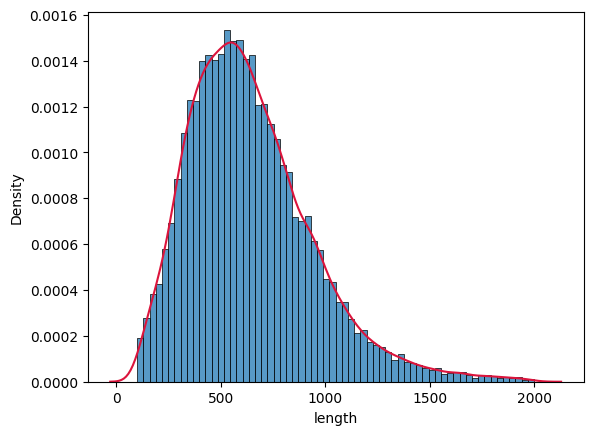

In [21]:
ax = sns.histplot(text_df['length'], kde=False, stat='density' )
sns.kdeplot(text_df['length'], color='crimson', ax=ax)

In [22]:


all_tokens = []

for token_list in text_df['tokens']:
    for word in token_list:
        all_tokens.append(word)

# Count occurrences of each token
token_counts = Counter(all_tokens)
top_words = pd.DataFrame(token_counts.most_common(20), columns = ['word','freq'])

print(top_words)


        word  freq
0     econom  9129
1       year  8497
2       said  8166
3     market  7298
4        rat  7193
5          u  6567
6      stock  6399
7        fed  5866
8        new  5689
9       pric  4922
10      perc  4456
11    invest  4379
12       bil  4322
13      bank  4314
14      trad  4128
15     would  4088
16  interest  3594
17      last  3577
18      high  3388
19       fin  3371


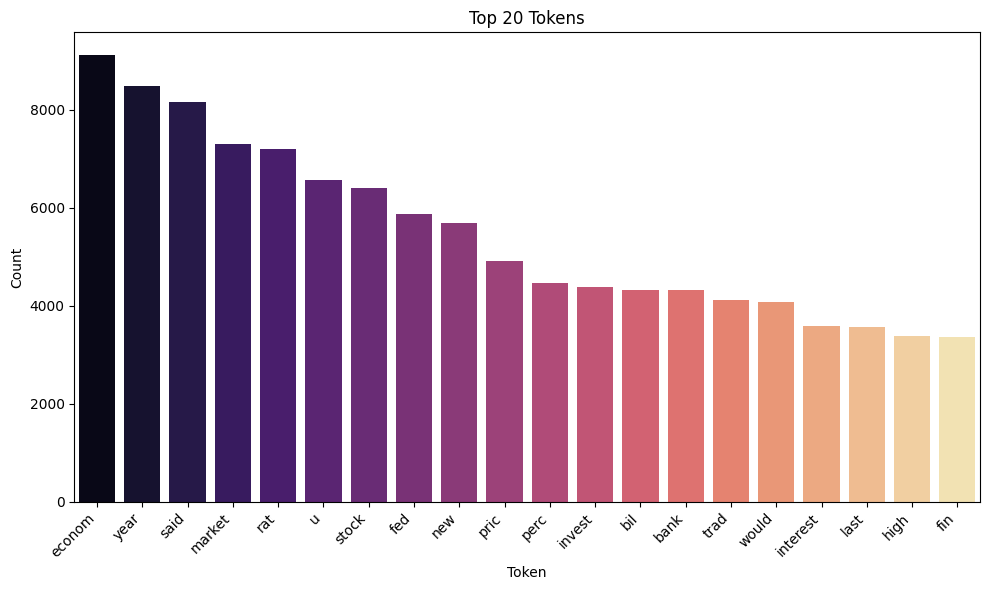

In [23]:
top_tokens = dict(token_counts.most_common(20))
# Plot the top 20 tokens
plt.figure(figsize=(10, 6))
ax = sns.barplot(top_words, x = 'word' , y='freq' , palette='magma')
plt.xlabel('Token')
plt.ylabel('Count')
plt.title('Top 20 Tokens')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [24]:
all_econ_tokens = []

econ_df = text_df.loc[text_df['class'] == 1]

for token_list in econ_df['tokens']:
    for word in token_list:
        all_econ_tokens.append(word)

# Count occurrences of each token
econ_token_counts = Counter(all_econ_tokens)

top_econ_tokens_tup = econ_token_counts.most_common(50)

top_econ_tokens_list = [token for token, _ in econ_token_counts.most_common(50)]

# Print the top 50 tokens and their counts
for token, count in econ_token_counts.most_common(50):
    print(f"{token}: {count}")

econom: 9129
rat: 3630
year: 3338
said: 3234
u: 2896
fed: 2867
market: 2384
grow: 2177
pric: 2024
new: 1917
perc: 1893
infl: 1760
interest: 1601
would: 1562
bank: 1528
invest: 1497
increas: 1450
stock: 1446
last: 1377
report: 1338
high: 1334
trad: 1245
bil: 1240
fin: 1238
nat: 1228
govern: 1201
week: 1157
stat: 1154
presid: 1125
low: 1118
tax: 1103
expect: 1084
off: 1035
produc: 1017
doll: 1007
ev: 1006
ri: 1005
say: 999
recess: 986
reserv: 985
point: 970
consum: 960
month: 960
policy: 958
tim: 950
on: 935
may: 933
could: 933
spend: 927
sint: 918


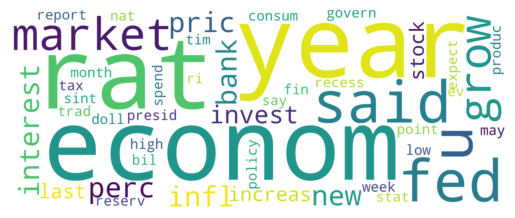

In [25]:
def word_cloud(tokens):
    #Creation of wordcloud
    wordcloud = WordCloud(
        max_font_size=100,
        max_words=50,
        background_color="white",
        scale=10,
        width=500,
        height=200
    ).generate(" ".join(top_econ_tokens_list))
    #Figure properties
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

word_cloud(top_econ_tokens_list)

In [26]:
all_nonecon_tokens = []

nonecon_df = text_df.loc[text_df['class'] == 0]

for token_list in nonecon_df['tokens']:
    for word in token_list:
        all_nonecon_tokens.append(word)

# Count occurrences of each token
nonecon_token_counts = Counter(all_nonecon_tokens)

top_nonecon_tokens_tup = nonecon_token_counts.most_common(50)

top_nonecon_tokens_list = [token for token, _ in nonecon_token_counts.most_common(50)]

# Print the top 50 tokens and their counts
for token, count in nonecon_token_counts.most_common(50):
    print(f"{token}: {count}")

year: 5159
stock: 4953
said: 4932
market: 4914
new: 3772
u: 3671
rat: 3563
bil: 3082
fed: 2999
pric: 2898
trad: 2883
invest: 2882
bank: 2786
company: 2694
mil: 2668
perc: 2563
would: 2526
off: 2242
last: 2200
week: 2145
fin: 2133
high: 2054
interest: 1993
point: 1939
increas: 1892
shar: 1865
on: 1834
stat: 1797
cent: 1749
av: 1745
fund: 1700
yesterday: 1575
govern: 1571
report: 1566
tim: 1540
work: 1537
say: 1527
presid: 1480
day: 1467
mak: 1457
nat: 1456
first: 1450
bond: 1444
clos: 1436
low: 1425
index: 1411
doll: 1408
gain: 1403
also: 1397
ev: 1384


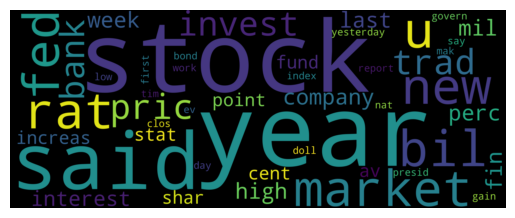

In [27]:
def word_cloud(tokens):
    #Creation of wordcloud
    wordcloud = WordCloud(
        max_font_size=100,
        max_words=50,
        background_color="black",
        scale=10,
        width=500,
        height=200
    ).generate(" ".join(top_nonecon_tokens_list))
    #Figure properties
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

word_cloud(top_nonecon_tokens_list)

In [28]:

top_econ_words_df = pd.DataFrame(econ_token_counts.most_common(20), columns = ['word','freq'])

top_nonecon_words_df = pd.DataFrame(nonecon_token_counts.most_common(20), columns = ['word','freq'])


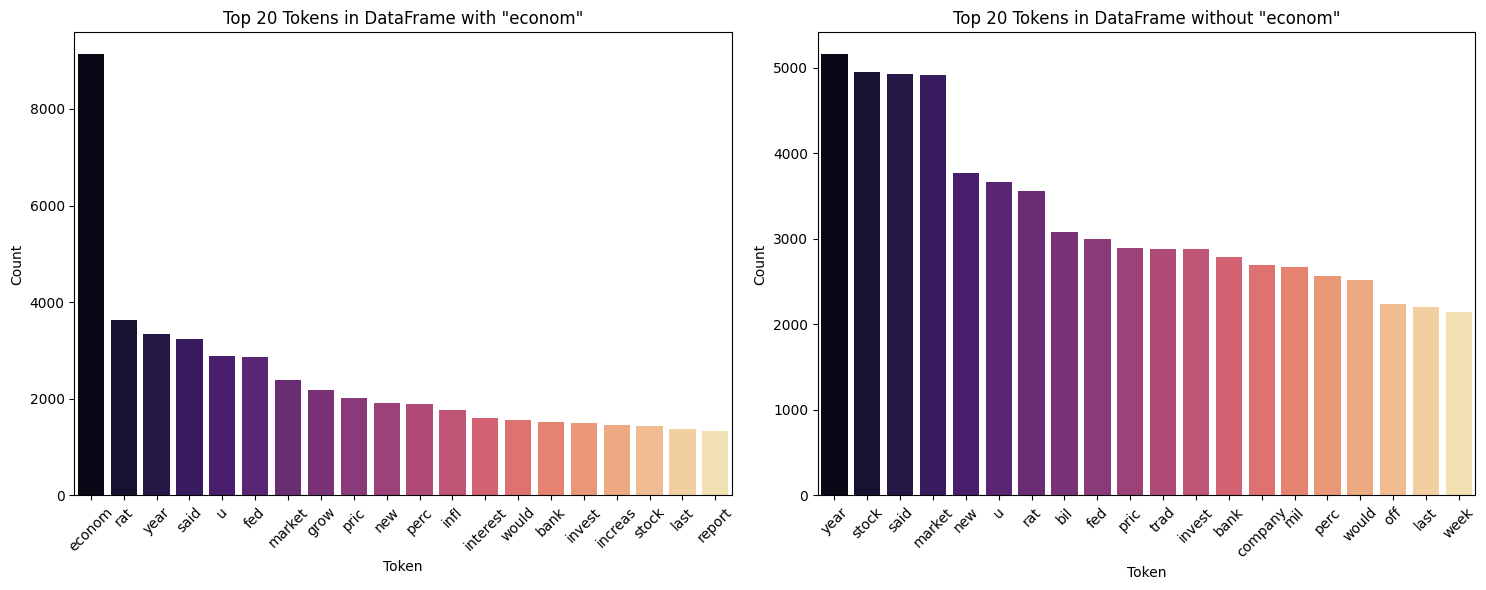

In [29]:
# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Plot top tokens in DataFrame with 'econom'
sns.barplot(data=top_econ_words_df, x='word', y='freq', ax=axs[0], palette='magma')
axs[0].set_title('Top 20 Tokens in DataFrame with "econom"')
axs[0].set_xlabel('Token')
axs[0].set_ylabel('Count')
axs[0].tick_params(axis='x', labelrotation=45)

# Plot top tokens in DataFrame without 'econom'
sns.barplot(data=top_nonecon_words_df, x='word', y='freq', ax=axs[1], palette='magma')
axs[1].set_title('Top 20 Tokens in DataFrame without "econom"')
axs[1].set_xlabel('Token')
axs[1].set_ylabel('Count')
axs[1].tick_params(axis='x', labelrotation=45)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

## Neural Network

### Splitting and transforming the data

In [30]:
X_train, X_test, y_train, y_test = train_test_split(text_df[['text']], text_df['class'], test_size=0.3, stratify = text_df['class'],random_state = 4)

In [31]:
bow_transformer = CountVectorizer(analyzer=text_processing).fit(X_train['text'])

In [32]:
X_train_bow = bow_transformer.transform(X_train['text'])
X_test_bow = bow_transformer.transform(X_test['text'])

In [33]:
print('Shape of Sparse Matrix: ', X_train_bow.shape, X_test_bow.shape)
print('Amount of Non-Zero occurences: ', X_train_bow.nnz,  X_test_bow.nnz)

Shape of Sparse Matrix:  (10904, 23875) (4674, 23875)
Amount of Non-Zero occurences:  537100 226174


In [34]:
max_abs_scaler = preprocessing.MaxAbsScaler()

In [35]:
# max_abs_scaler.fit(X_train_bow)
# # transform
# X_train_bow_scaled = max_abs_scaler.transform(X_train_bow)
# X_test_bow_scaled = max_abs_scaler.transform(X_test_bow)

In [36]:
X_train_bow_scaled_array = X_train_bow.toarray()
X_test_bow_scaled_array = X_test_bow.toarray()
#X_train_tfidf_array = X_train_tfidf.toarray()


In [37]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer().fit(X_train_bow)

In [38]:
X_train_tfidf = tfidf_transformer.transform(X_train_bow)
X_test_tfidf = tfidf_transformer.transform(X_test_bow)

In [39]:
X_train_tfidf_array = X_train_tfidf.toarray()
X_test_tfidf_array = X_test_tfidf.toarray()

In [40]:
X_train_bow_scaled_array.shape

(10904, 23875)

In [41]:
y_train.shape

(10904,)

In [42]:
y_train_categorical = to_categorical(y_train, num_classes=2)
y_test_categorical = to_categorical(y_test, num_classes=2)

In [43]:
y_train_categorical.shape

(10904, 2)

In [44]:
from tensorflow.keras.layers import BatchNormalization

nrows, nfeat = X_test_tfidf.shape 

model = Sequential()
model.add(Input(shape=(nfeat,)))
model.add(BatchNormalization())
model.add(Dense(50, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization             │ (None, 23875)          │        95,500 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │     1,193,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           102 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,294,502 (4.94 MB)

 Trainable params: 1,246,752 (4.76 MB)

 Non-trainable params: 47,750 (186.52 KB)

In [45]:
#optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)
model.compile(loss="binary_crossentropy", 
              optimizer='adam', 
              metrics=['accuracy'])

In [46]:
model_history = model.fit(X_train_tfidf_array, y_train_categorical, epochs=50,
                          validation_split=.3,
                          batch_size=32
                          )

Epoch 1/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7592 - loss: 0.4986 - val_accuracy: 0.4108 - val_loss: 0.6973
Epoch 2/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9578 - loss: 0.1195 - val_accuracy: 0.8741 - val_loss: 0.3373
Epoch 3/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9829 - loss: 0.0491 - val_accuracy: 0.9141 - val_loss: 0.3286
Epoch 4/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9909 - loss: 0.0236 - val_accuracy: 0.8695 - val_loss: 0.3319
Epoch 5/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9939 - loss: 0.0186 - val_accuracy: 0.9184 - val_loss: 0.3075
Epoch 6/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9945 - loss: 0.0198 - val_accuracy: 0.9297 - val_loss: 0.2696
Epoch 7/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9970 - loss: 0.0142 - val_accuracy: 0.9202 - val_loss: 0.3596
Epoch 8/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9973 - loss: 0.0068 - val_accuracy: 0

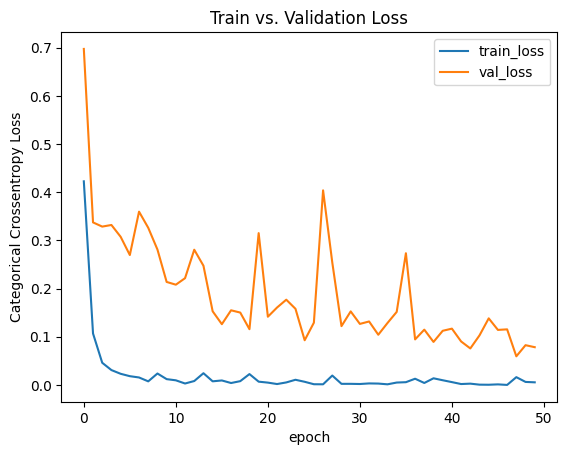

In [47]:
plt.plot(model_history.history['loss'], label='train_loss')
plt.plot(model_history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Train vs. Validation Loss')
plt.xlabel('epoch')
plt.ylabel('Categorical Crossentropy Loss')
plt.show()

In [48]:
# Make predictions using your trained neural network
nn_y_pred = model.predict(X_test_tfidf_array)

# Define an initial threshold
threshold = 0.5

# Calculate the proportion of predicted 1s
proportion_1s = np.mean(nn_y_pred[:, 1])

# Adjust the threshold based on the proportion of 1s
if proportion_1s > 0.5:
    threshold -= 0.05  # Decrease the threshold if there are too many 1s
else:
    threshold += 0.05  # Increase the threshold if there are too few 1s

# Threshold the probabilities to get the predicted classes
y_pred_int = (nn_y_pred[:, 1] > threshold).astype(int)

# Now you can evaluate the predictions as usual

147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [49]:
len(y_pred_int)

4674

In [50]:
# y_pred_int = np.argmax(nn_y_pred, axis=1)

In [51]:
report = classification_report(y_test, y_pred_int)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      3094
           1       0.99      0.98      0.98      1580

    accuracy                           0.99      4674
   macro avg       0.99      0.99      0.99      4674
weighted avg       0.99      0.99      0.99      4674



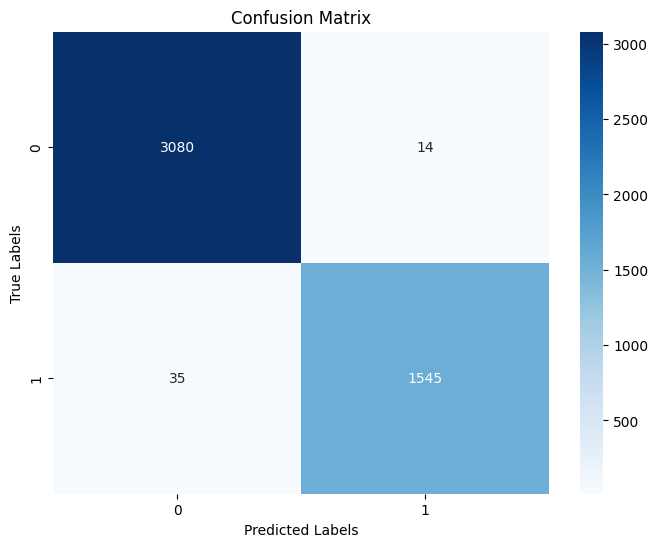

In [52]:
cm = confusion_matrix(y_test, y_pred_int)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [53]:
y_pred_int

array([0, 0, 1, ..., 1, 0, 1])

In [55]:
text_bow_transformer = CountVectorizer(analyzer=text_processing).fit(text_df['text'])

In [56]:
text_bow = bow_transformer.transform(text_df['text'])

In [57]:
max_abs_scaler.fit(text_bow)

# text_bow_scaled = max_abs_scaler.transform(text_bow)

MaxAbsScaler()

In [58]:
text_tfidf_transformer = TfidfTransformer().fit(text_bow)

In [59]:
text_tfidf = tfidf_transformer.transform(text_bow)

In [60]:
text_tfidf_array = text_tfidf.toarray()

In [61]:
nn_class_pred = model.predict(text_tfidf_array)

487/487 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [62]:
len(nn_class_pred)

15578

In [64]:
# Given threshold
threshold = 0.0000000000146

# Target sum
target_sum = 7789

# Define the lower and upper bounds
lower_bound = 0.0
upper_bound = 1.0

# Perform binary search to find the optimal threshold
while True:
    # Compute the new threshold
    new_threshold = (lower_bound + upper_bound) / 2
    
    # Generate predictions using the new threshold
    prediction_unseen_classes = [1 if (prob[1] > new_threshold or class_val == 1) else 0 
                                  for prob, class_val in zip(nn_class_pred, text_df['class'])]
    
    # Compute the sum of predictions
    current_sum = sum(prediction_unseen_classes)
    
    # Check if the current sum matches the target sum
    if current_sum == target_sum:
        break
    elif current_sum < target_sum:
        upper_bound = new_threshold
    else:
        lower_bound = new_threshold

# Update the threshold
threshold = new_threshold

# Print the updated threshold
print("Updated threshold:", threshold)


Updated threshold: 1.4722445484949276e-10


In [90]:
# Calculate the predictions based on the threshold directly from nn_class_pred
prediction_unseen_classes = [1 if prob[1] > threshold else 0 for prob in nn_class_pred]

In [91]:
text_df['predictions'] = prediction_unseen_classes

In [92]:
# Assuming text_df is your DataFrame
text_df.loc[(text_df['class'] == 1) & (text_df['predictions'] == 0), 'predictions'] = 1

KeyError: 'class'

In [93]:
sum(text_df['predictions'])


7782

In [ ]:
import pandas as pd

# Assuming nn_class_pred is a list of probabilities
# Convert nn_class_pred to a DataFrame
df = pd.DataFrame(nn_class_pred, columns=['idk', 'Probability'])


# Display the DataFrame
print(df)


In [ ]:
for prob in nn_class_pred:
    print(prob)

In [ ]:
# Calculate the predictions based on the threshold directly from nn_class_pred
prediction_unseen_classes = [1 if prob[0] > 0.0000000000146 else 0 for prob in nn_class_pred]

# No need to use np.ravel() here


In [ ]:
len(prediction_unseen_classes)

In [ ]:
class_pred_int = np.argmax(nn_class_pred, axis=1)

In [88]:
text_df['predictions'] = prediction_unseen_classes

In [89]:
sum(text_df['predictions'])

7782

In [ ]:
import pandas as pd

# Assuming text_df is your DataFrame
filtered_df = text_df[(text_df['class'] == 1) & (text_df['predictions'] == 0)]

# Display the filtered DataFrame
print(filtered_df)


In [71]:
# Assuming text_df is your DataFrame
text_df.loc[(text_df['class'] == 1) & (text_df['predictions'] == 0), 'predictions'] = 1


In [83]:
sum(text_df['predictions'])

KeyError: 'predictions'

In [75]:

preds = text_df['predictions']

predictions_df = pd.DataFrame({'predictions': preds})

header = pd.DataFrame({
    'predictions': [21108082, 'KentoNanami']
})

header

output_df = pd.concat([header, predictions_df], axis=0)

# Specify the path where you want to save the CSV file
output_csv_path = "/Users/andrew/Downloads/UW courses/ECON 626/Prediction Competition 6/predictions2.csv"

# Write the combined DataFrame to a CSV file
output_df.to_csv(output_csv_path, index=False, header=False)





In [ ]:
preds

In [76]:
import pandas as pd

# Assuming text_df is your DataFrame
text_df['class'].to_csv('class_column.csv', index=False)


In [85]:
response_data_path = "/Users/andrew/Downloads/UW courses/ECON 626/Prediction Competition 6/MLforEcon_W2024_pc6_with_response_v1.csv"
response_df= pd.read_csv(response_data_path)

In [87]:
response_df

,response,text
0,1,"CEA believe that some special factors, such as..."
1,0,approved a $282.6 billion measure to fund the ...
2,0,(AP) ÛÓ An unexpectedly quick rise in. the pr...
3,1,$17.28 million would be put into a reserve for...
4,0,Reserve policy makers voted to keep short-term...
...,...,...
15573,1,Grover Norquist says emphatically and repeated...
15574,1,"in die economy, Laura DÛªAndrea Tyson, chairm..."
15575,1,of living are not rising noticeably. Many of t...
15576,1,economy merely flexes some long-unused muscles...
